# XED data

In [1]:
import polars as pl
import os 
# get all files per country
path = "emotion-data/XED"
files = os.listdir(path)

In [2]:
df = pl.DataFrame()
schema = {"text":pl.String,
          "labels":pl.String,
         "language":pl.String}
for f in files:
    tmp = pl.read_csv(path+"/"+f, separator="\t",schema=schema, ignore_errors=True)
    lang = f.split("-")[0]
    tmp = tmp.with_columns(language=pl.Series([lang]*len(tmp)))
    if tmp.is_empty():
        df=tmp
    else:
        df=pl.concat([df,tmp],how="vertical")

In [3]:
df["labels"].unique()
df

text,labels,language
str,str,str
"""Da nam nisu ucjenjene glave, z…","""4""","""hr"""
"""Zašto ne popijemo piće za dobr…","""2, 5""","""hr"""
"""Neće moći.""","""3""","""hr"""
"""Ovdje više tako ne ide Kid.""","""6""","""hr"""
"""Nikom nije stalo.""","""1, 3""","""hr"""
…,…,…
"""Ez da ezer gertatzen, David.""","""5, 6, 8""","""eu"""
"""Pentsatuko zenuela zin egin du…","""1, 6""","""eu"""
"""Tonia!""","""5, 7""","""eu"""


In [8]:
# exclude languages not present in parlamint 4.0 dataset
# language codes by ISO 639 in parlamint
lang_codes = ["bs","bg","hr","cs","da","nl","en","et","fi","fr","de",
                 "hu","is","it","lv","el","no","pl","pt","ru","sr","sl",
                 "es","sv","tr","uk"]

# exclude langs
df = df.filter(pl.col("language").is_in(lang_codes))

In [9]:
import pandas as pd

df = pd.DataFrame(df)

df.columns = ['text', 'labels', 'lang']

In [10]:
# convert string labels to list and recode from 0 to n-1
# df = df.with_columns(pl.col("labels").map_elements(lambda s: [[int(x)-1] for x in s.split(",") if x.isdigit]))
import numpy as np

def to_array(string):
    string = string.replace(" ", "")
    number_list = string.split(',')
    number_list = [int(num) for num in number_list]
    number_array = np.array(number_list)
    
    return number_array

df.labels = df['labels'].apply(to_array)
df

,text,labels,lang
0,"Da nam nisu ucjenjene glave, zbrisali bi iz ov...",[4],hr
1,Zašto ne popijemo piće za dobra stara vremena.,"[2, 5]",hr
2,Neće moći.,[3],hr
3,Ovdje više tako ne ide Kid.,[6],hr
4,Nikom nije stalo.,"[1, 3]",hr
...,...,...,...
170912,Your opinion might be valuable .,[8],en
170913,Your orders .,[8],en
170914,Your ship's been in lots of battles .,[8],en
170915,"Your wine , your Majesty .",[8],en


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer


def one_hot_encoding(ds):
    mlb = MultiLabelBinarizer()
    ds = ds.join(pd.DataFrame(mlb.fit_transform(ds.pop('labels')),
                          columns=mlb.classes_,
                          index=ds.index))
    
    return ds

df = one_hot_encoding(df)



In [12]:
#df = df.with_columns(pl.col('text').map_elements(lambda x: len(x)).alias('len_text'))
df
# Compute the mean length
#mean_length = df.select(pl.col('StringLength').mean())
#df['len_text'].mean()

,text,lang,1,2,3,4,5,6,7,8
0,"Da nam nisu ucjenjene glave, zbrisali bi iz ov...",hr,0,0,0,1,0,0,0,0
1,Zašto ne popijemo piće za dobra stara vremena.,hr,0,1,0,0,1,0,0,0
2,Neće moći.,hr,0,0,1,0,0,0,0,0
3,Ovdje više tako ne ide Kid.,hr,0,0,0,0,0,1,0,0
4,Nikom nije stalo.,hr,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
170912,Your opinion might be valuable .,en,0,0,0,0,0,0,0,1
170913,Your orders .,en,0,0,0,0,0,0,0,1
170914,Your ship's been in lots of battles .,en,0,0,0,0,0,0,0,1
170915,"Your wine , your Majesty .",en,0,0,0,0,0,0,0,1


In [29]:
# delete combinations with less than 100 instances
#labels = df[['1', '2', '3', '4', '5', '6', '7', '8']]
#print( )
#labels_vectors = labels.values.tolist()

df.columns = ['text', 'lang', '1', '2', '3', '4', '5', '6', '7', '8']

In [30]:
freqs = list()

for i in range(1,9):
    freqs.append(df[str(i)].sum())
    print(i, df[str(i)].sum())
    


1 43095
2 38058
3 21538
4 25621
5 28559
6 26533
7 27320
8 28728


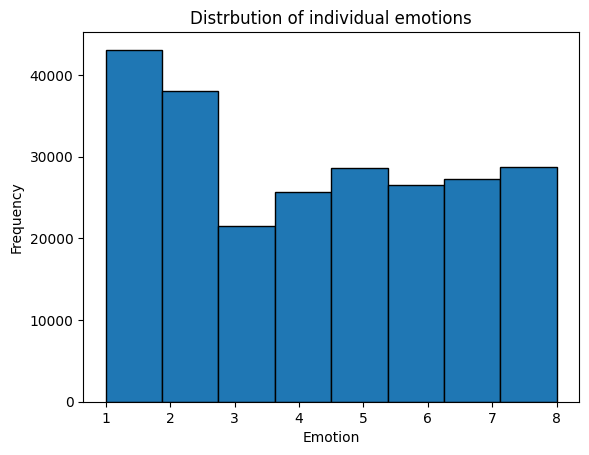

In [31]:
import matplotlib.pyplot as plt

values = []
for i, freq in enumerate(freqs):
    values.extend([i+1] * freq)  # i+1 to match the value (1, 2, 3, 4, 5)

# Step 3: Create a pandas DataFrame
df = pd.DataFrame(values, columns=['Value'])

# Step 4: Plot the histogram
plt.hist(df['Value'], bins=len(freqs), edgecolor='black')

# Customizing the histogram
plt.title('Distrbution of individual emotions')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(range(1, len(freqs) + 1))

# Show the plot
plt.show()

In [125]:
from collections import defaultdict

d = defaultdict(int)

for _, r in df.iterrows():
    dat = list(r)[2:10]
    d[tuple(dat)] += 1

In [127]:
for k in sorted(d, key = d.get, reverse=True):
    print(k, d[k])

(1, 0, 0, 0, 0, 0, 0, 0) 28288
(0, 1, 0, 0, 0, 0, 0, 0) 23252
(0, 0, 0, 0, 0, 0, 1, 0) 16253
(0, 0, 0, 0, 0, 0, 0, 1) 16048
(0, 0, 0, 1, 0, 0, 0, 0) 15876
(0, 0, 0, 0, 0, 1, 0, 0) 15721
(0, 0, 0, 0, 1, 0, 0, 0) 15381
(0, 0, 1, 0, 0, 0, 0, 0) 10293
(1, 0, 1, 0, 0, 0, 0, 0) 7197
(0, 0, 0, 0, 1, 0, 0, 1) 6070
(0, 1, 0, 0, 1, 0, 0, 0) 5519
(0, 1, 0, 0, 0, 0, 0, 1) 3449
(0, 0, 0, 0, 0, 1, 1, 0) 3156
(1, 1, 0, 0, 0, 0, 0, 0) 3020
(0, 0, 0, 1, 0, 1, 0, 0) 2376
(0, 0, 1, 0, 0, 1, 0, 0) 2015
(1, 0, 0, 1, 0, 0, 0, 0) 1944
(1, 0, 0, 0, 0, 0, 1, 0) 1936
(1, 0, 0, 0, 0, 1, 0, 0) 1932
(0, 0, 0, 0, 1, 0, 1, 0) 1841
(0, 1, 0, 0, 1, 0, 0, 1) 1835
(0, 1, 0, 0, 0, 0, 1, 0) 1789
(0, 1, 0, 1, 0, 0, 0, 0) 1730
(0, 0, 0, 1, 0, 0, 1, 0) 1535
(0, 0, 0, 1, 0, 0, 0, 1) 1427
(1, 0, 1, 0, 0, 1, 0, 0) 1044
(1, 0, 0, 0, 0, 0, 0, 1) 777
(0, 0, 0, 0, 0, 1, 0, 1) 649
(0, 1, 0, 0, 1, 0, 1, 0) 618
(0, 0, 0, 0, 0, 0, 1, 1) 586
(1, 0, 1, 0, 0, 0, 1, 0) 564
(0, 1, 0, 0, 0, 1, 0, 0) 537
(1, 0, 1, 1, 0, 0, 0, 0) 535
(0, 0, 1,

In [128]:
len(d)

224

## Modeling

In [ ]:
id2labels = {'0':"anger",
            '1':"anticipation",
              '2':"disgust",
              '3':"fear",
              '4':"joy",
              '5':"sadness",
              '6':"surprise",
              '7':"trust",
             }

# change order key value to recode through retrieval
labels2id = {v:k for k,v in labels_xed.items()}